# GPU Speedup of Motif Analysis
---

Here, we measure [`netsci`](https://github.com/gialdetti/netsci) speedup resulting from the GPU-based algorithm. Specificaly, we compare the running times between CPU and GPU over several networks sizes ($n$) and sparsities ($p$).

In [1]:
# Install packages (e.g., for Google Colab)

# !pip install netsci                                               # Install latest release version
!pip install git+https://github.com/gialdetti/netsci.git          # Install latest development version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gialdetti/netsci.git to /tmp/pip-req-build-fxwxnwcc
  Running command git clone -q https://github.com/gialdetti/netsci.git /tmp/pip-req-build-fxwxnwcc


In [2]:
import logging; logging.basicConfig()
import itertools

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import tensorflow as tf

from netsci.models.random import erdos_renyi
import netsci.metrics.motifs as nsm


tqdm.pandas()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib
import re


def parse_description(physical_device_desc):
    return dict(re.findall(r"([^,:]*): ([^,]*)[,\s]*", physical_device_desc))


# descriptions = [
#     "",
#     "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5",
#     "device: 0, name: METAL, pci bus id: <undefined>",
# ]
# [parse_description(d) for d in descriptions]


def get_gpu_model():
    device_names = {
        d.name: parse_description(d.physical_device_desc).get("name", "")
        for d in device_lib.list_local_devices()
    }

    return device_names["/device:GPU:0"]


gpu_model = get_gpu_model()
print(f'GPU model: {gpu_model}')

GPU model: Tesla T4


In [4]:
import time

class Timer:
    def __init__(self, logger=None, desc='Execution'):
        self.logger = logger
        self.desc = desc

    def __enter__(self):
        self.start = time.time_ns()
        return self

    def __exit__(self, *args):
        self.end = time.time_ns()
        self.interval = (self.end - self.start)
        self.interval_ms = self.interval // 1_000_000

        if self.logger is not None:
            self.logger(f'{self.desc} took {self.interval_ms/1000:.03f} sec.')

## Sanity checks

In [5]:
# from netsci.metrics.motifs_gpu import _motifs_gpu
# help(_motifs_gpu)

In [6]:
# A = erdos_renyi(n=1000, p=0.01, random_state=71070)

# logging.getLogger('netsci.metrics.motifs_gpu').setLevel(logging.DEBUG)
# with tf.device('/CPU:0'):
#     print(_motifs_gpu(A))

# with tf.device('/GPU:0'):
#     print(_motifs_gpu(A))

GPU usage

In [7]:
A = erdos_renyi(n=1000, p=0.01, random_state=71070)

logging.getLogger('netsci.metrics.motifs_gpu').setLevel(logging.DEBUG)
with tf.device('/CPU:0'):
    print(nsm.motifs(A, algorithm='gpu'))

with tf.device('/GPU:0'):
    print(nsm.motifs(A, algorithm='gpu'))

DEBUG:netsci.metrics.motifs_gpu:Ax devices: ['device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0']
DEBUG:netsci.metrics.motifs_gpu:f devices: ['device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0']
DEBUG:netsci.metrics.motifs_gpu:Ax devices: ['device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0']


[156453141   9481653     37283     95997     47667     48287      1001
       843       769       334         2         9         5         9
         0         0]


DEBUG:netsci.metrics.motifs_gpu:f devices: ['device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0']


[156453141   9481653     37283     95997     47667     48287      1001
       843       769       334         2         9         5         9
         0         0]


GPU timing

In [8]:
with Timer(logger=print, desc='GPU') as t:
  with tf.device('/GPU:0'):
    print(nsm.motifs(A, algorithm='gpu'))
print(t.interval_ms)

with Timer(logger=print, desc='CPU'):
  with tf.device('/CPU:0'):
    print(nsm.motifs(A, algorithm='gpu'))


DEBUG:netsci.metrics.motifs_gpu:Ax devices: ['device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0']
DEBUG:netsci.metrics.motifs_gpu:f devices: ['device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0', 'device:GPU:0']
DEBUG:netsci.metrics.motifs_gpu:Ax devices: ['device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0']


[156453141   9481653     37283     95997     47667     48287      1001
       843       769       334         2         9         5         9
         0         0]
GPU took 0.343 sec.
343


DEBUG:netsci.metrics.motifs_gpu:f devices: ['device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0', 'device:CPU:0']


[156453141   9481653     37283     95997     47667     48287      1001
       843       769       334         2         9         5         9
         0         0]
CPU took 3.010 sec.


## Experiments

Experiment configurations

In [9]:
ns = np.arange(0, 3500, 500)[1:]
ps = np.linspace(0, 0.4, 8+1)[1:]
print(ns, ps)
devices = ('/GPU:0', '/CPU:0')
n_repetitions = 5
  
# ns, ps = ns[:2], ps[:3]
experiments = pd.DataFrame(itertools.product(ns, ps, devices, [gpu_model], np.arange(n_repetitions)), 
                           columns=['n', 'p', 'device', 'device_model', 'repetition']) \
  .assign(random_state=71070, device_model=lambda df: df['device_model'].where(df['device']=='/GPU:0'))

# display(experiments.agg(['nunique']))
experiments

[ 500 1000 1500 2000 2500 3000] [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4 ]


,n,p,device,device_model,repetition,random_state
0,500,0.05,/GPU:0,Tesla T4,0,71070
1,500,0.05,/GPU:0,Tesla T4,1,71070
2,500,0.05,/GPU:0,Tesla T4,2,71070
3,500,0.05,/GPU:0,Tesla T4,3,71070
4,500,0.05,/GPU:0,Tesla T4,4,71070
...,...,...,...,...,...,...
475,3000,0.40,/CPU:0,NaN,0,71070
476,3000,0.40,/CPU:0,NaN,1,71070
477,3000,0.40,/CPU:0,NaN,2,71070
478,3000,0.40,/CPU:0,NaN,3,71070


Run experiments

In [10]:
logging.getLogger('netsci.metrics.motifs_gpu').setLevel(logging.INFO)


def measure(A, device):
  timestamp = pd.Timestamp.now()

  with Timer() as t:
    with tf.device(device):
      f = nsm.motifs(A, algorithm='gpu')
  return {
      'timestamp': timestamp,
      'computation_time': t.interval_ms / 1000,
      'motifs': f,
  }


times = experiments.join(
    experiments.sample(frac=1) \
    .progress_apply(lambda r: measure(erdos_renyi(r.n, r.p, random_state=r.random_state), r.device), axis=1) \
    .apply(pd.Series)
)
times

  0%|          | 0/480 [00:00<?, ?it/s]

,n,p,device,device_model,repetition,random_state,timestamp,computation_time,motifs
0,500,0.05,/GPU:0,Tesla T4,0,71070,2022-05-29 19:39:50.243962,0.048,"[15207804, 4818168, 126809, 254497, 127365, 12..."
1,500,0.05,/GPU:0,Tesla T4,1,71070,2022-05-29 19:43:37.884065,0.051,"[15207804, 4818168, 126809, 254497, 127365, 12..."
2,500,0.05,/GPU:0,Tesla T4,2,71070,2022-05-29 20:03:49.072928,0.050,"[15207804, 4818168, 126809, 254497, 127365, 12..."
3,500,0.05,/GPU:0,Tesla T4,3,71070,2022-05-29 20:25:49.869684,0.049,"[15207804, 4818168, 126809, 254497, 127365, 12..."
4,500,0.05,/GPU:0,Tesla T4,4,71070,2022-05-29 19:51:01.856163,0.051,"[15207804, 4818168, 126809, 254497, 127365, 12..."
...,...,...,...,...,...,...,...,...,...
475,3000,0.40,/CPU:0,NaN,0,71070,2022-05-29 20:16:51.048332,44.161,"[209616783, 838990685, 279309289, 559731871, 2..."
476,3000,0.40,/CPU:0,NaN,1,71070,2022-05-29 20:13:52.551391,50.667,"[209616783, 838990685, 279309289, 559731871, 2..."
477,3000,0.40,/CPU:0,NaN,2,71070,2022-05-29 20:01:43.163648,43.729,"[209616783, 838990685, 279309289, 559731871, 2..."
478,3000,0.40,/CPU:0,NaN,3,71070,2022-05-29 20:00:04.702457,48.687,"[209616783, 838990685, 279309289, 559731871, 2..."


In [11]:
# assert all(times.groupby(['n', 'p', 'random_state']).apply(lambda g: g['motifs'].values.std()==0))
assert all(times.groupby(['n', 'p', 'random_state']).apply(lambda g: len(np.unique(np.vstack(g['motifs']), axis=0))) == 1)

In [12]:
times.to_csv(f"gpu-speedup-times.{gpu_model}.Colab.{pd.Timestamp.now().strftime('(%y%m%d.%H%M%S)')}.csv", index=False)

## Results

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'

Text(289.00263671875, 0.5, 'Computation Time [sec]')

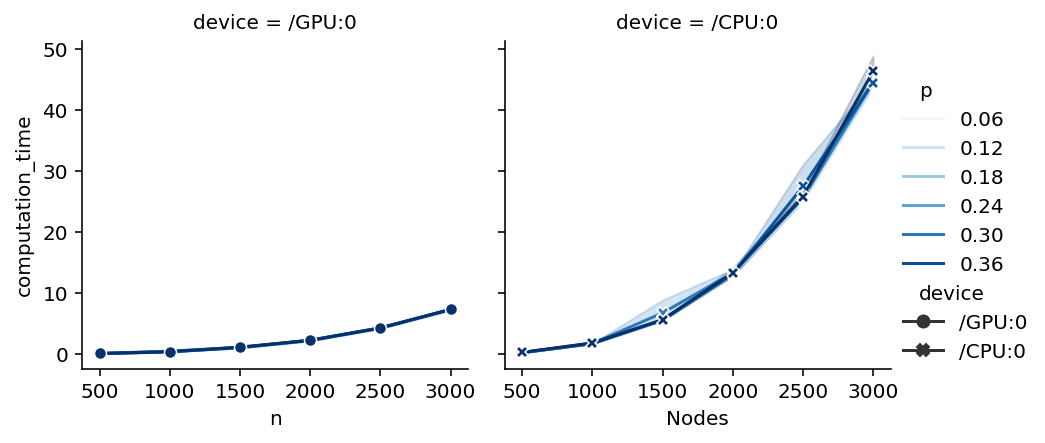

In [19]:
sns.relplot(x='n', y='computation_time', hue='p', col='device', data=times, 
            kind='line', markers=True, style='device', dashes=False, palette='Blues', height=3.2)
plt.xlabel('Nodes')
plt.ylabel('Computation Time [sec]')

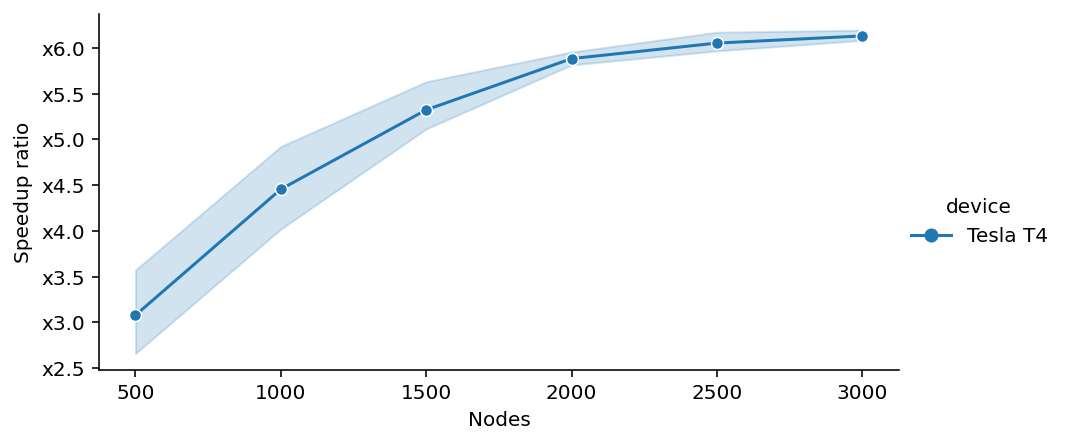

In [23]:
speedup = times.groupby(['n', 'p', 'device', 'random_state'])['computation_time'].mean().unstack(['device']) \
  .assign(speedup=lambda df: df['/CPU:0']/df['/GPU:0']).reset_index() \
  .assign(device=gpu_model)

sns.relplot(x='n', y='speedup', hue='device', style='device', data=speedup,
            kind='line', markers=True, height=3.2, aspect=2)
plt.xlabel('Nodes')
plt.ylabel('Speedup ratio')
plt.gca().set_yticklabels([f"x{t}" for t in plt.gca().get_yticks()]);